In [10]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils.helpers import load_h5, get_masks
from utils.transform import np_to_tt, apply_mask, ifft_2d,\
                            reshape_complex_channels_to_be_adj,\
                            combine_complex_channels, crop_center,\
                            root_sum_of_squares
from include.mri_helpers import get_scale_factor

In [49]:
def recon_ksp_to_img(ksp, dim=320):
    ''' given a 3D npy array (or torch tensor) ksp k-space e.g. shape (15,x,y)
        (1) perform ifft to img space
        (2) reshape/combine complex channels
        (3) combine multiple coils via root sum of squares
        (4) crop center portion of image according to dim
    '''

    if type(ksp).__module__ == np.__name__:
        ksp = np_to_tt(ksp)

    arr = ifft_2d(ksp).cpu().numpy()
    arr = reshape_complex_channels_to_be_adj(arr)
    
#     plt.hist(arr.flatten())
    arr = combine_complex_channels(arr) # e.g. shape (30,x,y) --> (15,x,y)
    arr = root_sum_of_squares(arr) # e.g. (15,x,y) --> (x,y)
    
    arr = crop_center(arr, dim, dim) # e.g. (x,y) --> (dim,dim)

    return arr

### Question to answer
- Can we take ifft_2d of complex-valued (15,x,y)?
    - Yes
- Are we zeroing out some information when combining complex channels or when performing rss operation?
    - No - np.count_nonzero() returns same value for each step
    - Scaling dynamic range to [0,255] doesn't help
- Because I'm taking from test set, perhaps the k-space is already undersampled? e.g. test to see if applying the mask makes a difference in number of non-zeros
    - Test 1: applying mask makes a very small difference - e.g. <1% of non-zero values become zero when mask is applied
    - Test 2: when plotting boolean k-space, it sure looks as if the values have already been zeroed
    - Currently downloading validation set. See if results of two tests are different there

### Load sample

In [86]:
file_id_list = ['1000411', '1000186', '1000361', '1001524', '1000799', '1001152', '1001132']

for file_id in file_id_list:
    
    f, slice_ksp = load_h5(file_id)
    
    mask, _, _ = get_masks(f, slice_ksp)
    
    ksp_premask = np_to_tt(slice_ksp).data.cpu().numpy()
    ksp_masked = apply_mask(np_to_tt(slice_ksp), mask=mask).data.cpu().numpy()
    
    
    # how much of a difference does it make to apply the mask?
    masked_out = np.count_nonzero(ksp_premask) - np.count_nonzero(ksp_masked)
    size_ksp = ksp_premask.size
    perc_pre_mask = np.count_nonzero(ksp_premask) / size_ksp
    perc_post_mask = np.count_nonzero(ksp_masked) / size_ksp
    print('% nonzeros pre-mask: {}, post-mask: {}. num zeroed: {}'.format(\
                np.round(perc_pre_mask,4), np.round(perc_post_mask,4), masked_out))
    
    
    # slice_ksp is (15,x,y) w complex entries
    img_gt = recon_ksp_to_img(slice_ksp) # skipped slice_ksp scaling

#     plt.imshow(img_gt, cmap='gray')
#     plt.axis('off')
#     plt.show()

% nonzeros pre-mask: 0.1141, post-mask: 0.1141. num zeroed: 0
% nonzeros pre-mask: 0.1129, post-mask: 0.1102. num zeroed: 19200
% nonzeros pre-mask: 0.2124, post-mask: 0.2097. num zeroed: 19199
% nonzeros pre-mask: 0.1505, post-mask: 0.1452. num zeroed: 38399
% nonzeros pre-mask: 0.2446, post-mask: 0.2339. num zeroed: 76796
% nonzeros pre-mask: 0.129, post-mask: 0.1237. num zeroed: 38400
% nonzeros pre-mask: 0.2554, post-mask: 0.2527. num zeroed: 19200


In [89]:
ksp_pre = np_to_tt(slice_ksp)

print(mask.shape, ksp_pre.shape)

out = ksp_pre * mask
out.shape

torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


torch.Size([15, 640, 368, 2])

In [98]:
def plot_boolean_kspace(ksp):
    ''' plot kspace whether values have been zeroed out or not '''
    
    ksp_pre_comb = combine_complex_channels(reshape_complex_channels_to_be_adj(ksp.numpy()))
    ksp_pre_cut = ksp_pre_comb[9, :50, :]

    ksp_boo = ksp_pre_cut > 0
    ksp_boo = ksp_boo.astype(int)

    plt.figure(figsize=(16, 16))
    plt.imshow(ksp_boo, cmap='gray')
    plt.show()

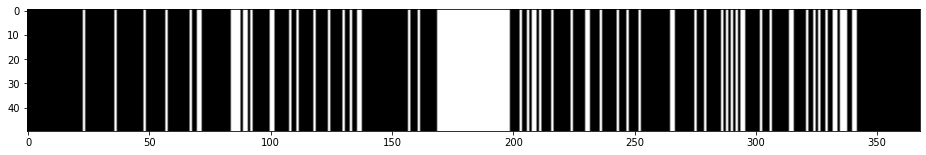

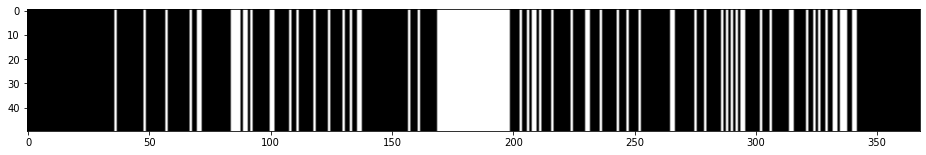

In [100]:
plot_boolean_kspace(ksp_pre)
plot_boolean_kspace(out)